<a href="https://colab.research.google.com/github/Ayushichadha/multiLayerPerceptron/blob/main/activations%26grads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Studying internals of MLPs with multiple layers and scrutinizing the statistics of the forward pass activations, backward pass gradients, and some of the pitfalls when they are improperly scaled. Also, looking at the typical diagnostic tools and visualizations we'd want to use to understand the health of our deep network. We learn why training deep neural nets can be fragile and introducing the first modern innovation that made doing so much easier: Batch Normalization.

Reading materials-



*   Neural Probabilistic Language Model paper (bengio et al.) - MLP
*   Kaiming init Paper
*   Batch Normalisation paper
*   Rethinking "batch" in Batch Norm paper





In [ ]:
# fixing the initial loss
# fixing the saturated tanh
# calculating the init scale: “Kaiming init”
# batch normalization
# real example: resnet50 walkthrough
# part2: PyTorch-ifying the code
# viz #1: forward pass activations statistics
# viz #2: backward pass gradient statistics
# the fully linear case of no non-linearities
# viz #3: parameter activation and gradient statistics
# viz #4: update:data ratio over time
# bringing back batchnorm, looking at the visualizations

Trying to build a strong intuitive understanding of activations and esp gradients that are flowing backwards and how they behave and look like.

important to understand the history of development of these architectures because we'll see that recurrent neural networks, while they are very impressive in that they are universal approximator and can in principle implement all the algorithms. But, they are not very easily optimizible with the first order gradient based techniques. Key to understand why they are not optimizable easily is to understand the activations and gradients and how they behave during training.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-08-04 09:14:09--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  1.37MB/s    in 0.2s    

2025-08-04 09:14:09 (1.37 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


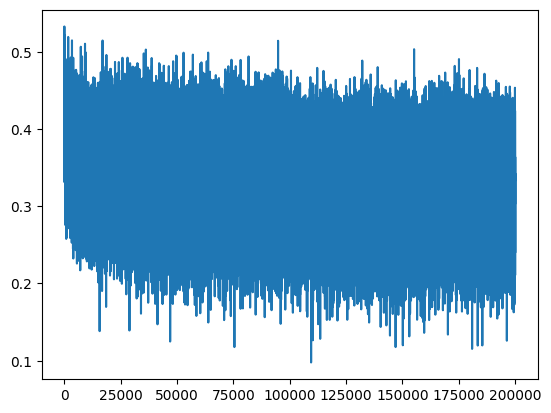

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674147605895996
val 2.1056840419769287


In [ ]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

fixing initial loss - initialising the weights and biases of the neural net. logits depend of w2, b2.

In [ ]:
# 4 dimensional example of the issue
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
#logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits,probs, loss

(tensor([1., 1., 1., 1.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [ ]:
# 4 dimensional example of the issue
logits = torch.randn(4) * 5
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits,probs, loss

(tensor([-0.2047, -6.0700,  8.4382, -1.5566]),
 tensor([1.7634e-04, 5.0014e-07, 9.9978e-01, 4.5627e-05]),
 tensor(0.0002))

fixing tanh activation values. pre activation values - are extreme and tanh is very active which leads to vlaues at tail ends of the tanh graph i.e. 0 gradients (see tanh part of autograd lecture). deriviative of tanh = (1 - tanh**2).out.grad. So, any values of tanh = -1, 1 would result in 0 gradient and eventually those neurons will not learn during backpropagation.

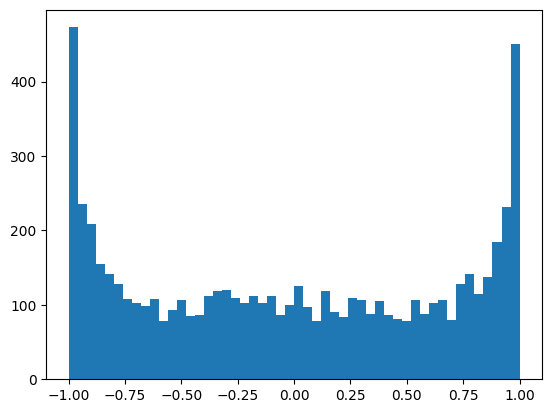

In [ ]:
# tanh activation values - okay now!
plt.hist(h.view(-1).tolist(), 50);

just to motivate discussion on Kaiming init.

In [ ]:
# instead of initializing the network by magic numbers hard coded,
# what's the method to come up with a value that helps to initialise large NN?

tensor(0.0048) tensor(1.0069)
tensor(0.0004) tensor(0.6292)


(array([7.07625531e-05, 3.53812766e-05, 3.53812766e-05, 2.83050213e-04,
        2.83050213e-04, 2.47668936e-04, 4.95337872e-04, 1.23834468e-03,
        2.33516425e-03, 2.97202723e-03, 5.20104766e-03, 9.51756340e-03,
        1.51785676e-02, 2.26086357e-02, 3.35060689e-02, 5.49471225e-02,
        8.10231233e-02, 1.21251635e-01, 1.70785422e-01, 2.38646710e-01,
        3.26392276e-01, 4.12191872e-01, 5.20670866e-01, 6.10680834e-01,
        6.88342736e-01, 6.94322171e-01, 6.65274143e-01, 5.76077945e-01,
        4.86669459e-01, 3.74263144e-01, 2.89595749e-01, 2.17347182e-01,
        1.50511951e-01, 1.04763960e-01, 6.90642519e-02, 4.69863353e-02,
        2.97202723e-02, 1.98842774e-02, 1.17112025e-02, 8.49150638e-03,
        4.59956595e-03, 2.90126468e-03, 1.98135149e-03, 1.48601362e-03,
        8.84531914e-04, 4.24575319e-04, 2.12287659e-04, 3.53812766e-05,
        7.07625531e-05, 3.53812766e-05]),
 array([-3.57792091, -3.43660323, -3.29528555, -3.15396787, -3.01265018,
        -2.8713325 , 

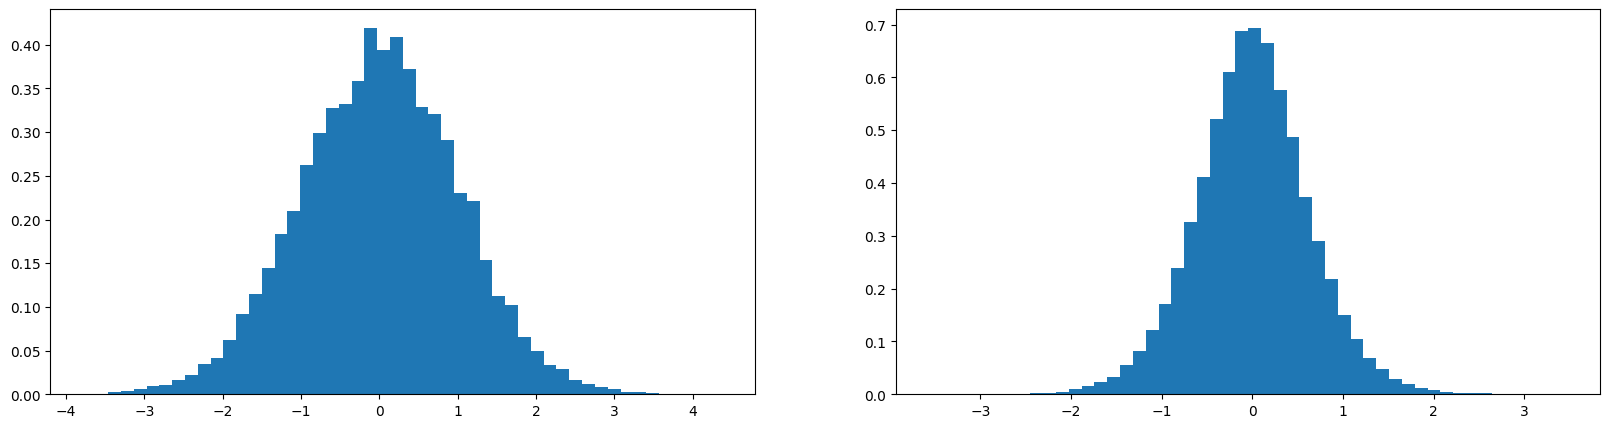

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

Some notes and links-

Linear Layer

CLASS torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)[SOURCE][SOURCE]
Applies an affine linear transformation to the incoming data:
y
=
x
A
T
+
b
y=xA
T
 +b.

This module supports TensorFloat32.

https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html

Batch Norm 1D

CLASS torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None.

https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html